In [ ]:
    
#!wget https://www.dropbox.com/scl/fo/ehrgul3wjxhs2aqq2wxut/h?rlkey=2gtjylmmtcz3l9tgypb775z3n
#!unzip h?rlkey=2gtjylmmtcz3l9tgypb775z3n

In [ ]:
#!pip install higra
#!pip install sap
#!pip install morphoaap

In [1]:

import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import higra as hg
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import sap
from PIL import Image
from matplotlib import colors
import sys
import time
#%matplotlib inline


################################################################################################################



def compute_AP(image, lamb_area, adj):
    nr, nc, bands = image.shape
    number_of_images_profile = ((len(lamb_area) * 2) + 1)
    AP_area = np.zeros((number_of_images_profile, nr, nc, bands))

    for i in range(bands):
        AP_area[:,:,:,i] = sap.attribute_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj ).data

    final_AP = AP_area[:,:,:,0] #np.concatenate([AP_area[:,:,:,0]],axis=0)
    for i in range(1, bands):
        final_AP = np.concatenate([ final_AP, AP_area[:,:,:,i] ],axis=0)

    return final_AP

def compute_MAX(image, lamb_area, adj):
    nr, nc, bands = image.shape
    number_of_images_profile = ((len(lamb_area) * 2) + 1)
    AP_area = np.zeros((number_of_images_profile, nr, nc, bands))

    for i in range(bands):
        AP_area[:,:,:,i] = sap.attribute_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj).data

    final_AP_max = np.concatenate([AP_area[len(lamb_area):number_of_images_profile,:,:,0]],axis=0)
    for i in range(1, bands):
        final_AP_max = np.concatenate([final_AP_max,AP_area[len(lamb_area):number_of_images_profile,:,:,i]],axis=0)

    return final_AP_max

def compute_MIN(image, lamb_area, adj):
    nr, nc, bands = image.shape
    number_of_images_profile = ((len(lamb_area) * 2) + 1)
    AP_area = np.zeros((number_of_images_profile, nr, nc, bands))

    for i in range(bands):
        AP_area[:,:,:,i] = sap.attribute_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj).data

    final_AP_min = np.concatenate([AP_area[0:len(lamb_area)+1,:,:,0]],axis=0)
    for i in range(1, bands):
        final_AP_min = np.concatenate([final_AP_min,AP_area[0:len(lamb_area)+1,:,:,i]],axis=0)

    return final_AP_min


def compute_SDAP(image, lamb_area, adj):
    nr, nc, bands = image.shape



    final_SDAP = sap.self_dual_attribute_profiles(np.ascontiguousarray(image[:,:,0]), {'area': lamb_area}, adjacency=adj)


    for i in range(1, bands):
        SDAP_area = sap.self_dual_attribute_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj)
        final_SDAP = sap.concatenate((final_SDAP,SDAP_area))

    final_SDAP = sap.vectorize(final_SDAP)

    return final_SDAP

def compute_ALPHA(image, lamb_area, adj):
    nr, nc, bands = image.shape
    ALPHA_area = sap.profiles.alpha_profiles(np.ascontiguousarray(image[:,:,0]), {'area': lamb_area}, adjacency=adj)

    ALPHA_profile = sap.concatenate((ALPHA_area))
    for i in range(1, bands):
        ALPHA_area = sap.profiles.alpha_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj)
        ALPHA_profile = sap.concatenate((ALPHA_profile,ALPHA_area))

    final_ALPHA = sap.vectorize(ALPHA_profile)

    return final_ALPHA

def compute_OMEGA(image, lamb_area, adj):
    nr, nc, bands = image.shape
    OMEGA_area = sap.profiles.omega_profiles(np.ascontiguousarray(image[:,:,0]), {'area': lamb_area}, adjacency=adj)
    OMEGA_profile = sap.concatenate((OMEGA_area))

    for i in range(1, bands):
        OMEGA_area = sap.profiles.omega_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj)
        OMEGA_profile = sap.concatenate((OMEGA_profile,OMEGA_area))

    final_OMEGA = sap.vectorize(OMEGA_profile)

    return final_OMEGA

def compute_LFAP(image, lamb_area, adj):
    nr, nc, bands = image.shape
    AP = sap.attribute_profiles(np.ascontiguousarray(image[:,:,0]), {'area': lamb_area}, adjacency=adj)
    for i in range(1, bands):
        AP = sap.concatenate((AP, sap.attribute_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj)))


    LFAP = sap.local_features(AP, local_feature=(np.mean, np.std), patch_size=7) #patch_size changed from 5 to 7 to match with the FP article
    LFAP = sap.vectorize(LFAP)

    return LFAP

def compute_LFSDAP(image, lamb_area, adj):
    nr, nc, bands = image.shape
    SDAP = sap.self_dual_attribute_profiles(np.ascontiguousarray(image[:,:,0]), {'area': lamb_area}, adjacency=adj)
    for i in range(1, bands):
        SDAP = sap.concatenate((SDAP, sap.self_dual_attribute_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj)))

    LFSDAP = sap.local_features(SDAP, local_feature=(np.mean, np.std), patch_size=7) #patch_size changed from 5 to 7 to match with the FP article
    LFSDAP = sap.vectorize(LFSDAP)

    return LFSDAP

def compute_HAP(image, lamb_area, adj):
    nr, nc, bands = image.shape
    AP = sap.attribute_profiles(np.ascontiguousarray(image[:,:,0]), {'area': lamb_area}, adjacency=adj)
    for i in range(1, bands):
        AP = sap.concatenate((AP, sap.attribute_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj)))

    nbins = 7 # number of bins
    w = 3 # local window size: 7x7
    pad = np.pad(AP, w, 'reflect')
    print("AP shape:", AP.shape)
    AP_padding= pad[w:AP.shape[0]+w,:,:]

    HAP = np.zeros((nbins*AP.shape[0],nr,nc))
    for k in range(0,HAP.shape[0]):
        AP_temp = AP_padding[k,:,:]
        vmin = np.amin(AP_temp)
        vmax = np.amax(AP_temp)
        for i in range(w,nr+w):
            for j in range(w,nc+w):
                patch_ij = AP_temp[i-w:i+w+1,j-w:j+w+1]
                HAP[k*nbins:(k+1)*nbins,i-w,j-w] = np.histogram(patch_ij,bins=nbins,range=(vmin,vmax))[0]

    return HAP

def compute_HSDAP(image, lamb_area, adj):
    nr, nc, bands = image.shape
    SDAP = sap.self_dual_attribute_profiles(np.ascontiguousarray(image[:,:,0]), {'area': lamb_area}, adjacency=adj)
    for i in range(1, bands):
        SDAP = sap.concatenate((SDAP, sap.self_dual_attribute_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, adjacency=adj)))

    nbins = 7 # number of bins
    w = 3 # local window size: 7x7
    SDAP_padding=np.pad(SDAP, w, 'reflect')[w:SDAP.shape[0]+w,:,:]

    HSDAP = np.zeros((nbins*SDAP.shape[0],nr,nc))
    for k in range(0,HSDAP.shape[0]):
        SDAP_temp = SDAP_padding[k,:,:]
        vmin = np.amin(SDAP_temp)
        vmax = np.amax(SDAP_temp)
        for i in range(w,nr+w):
            for j in range(w,nc+w):
                patch_ij = SDAP_temp[i-w:i+w+1,j-w:j+w+1]
                HSDAP[k*nbins:(k+1)*nbins,i-w,j-w] = np.histogram(patch_ij,bins=nbins,range=(vmin,vmax))[0]

    return HSDAP

def compute_FP(image, lamb_area, adj, method):
    nr, nc, bands = image.shape
    if (method == "FP_AREA_MEAN"):
        out_feature = {'mean_vertex_weights','area'}
    elif (method == "FP_AREA"):
        out_feature = {'area'}
    elif (method == "FP_MEAN"):
        out_feature = {'mean_vertex_weights'}

    FP_area = sap.feature_profiles(np.ascontiguousarray(image[:,:,0]), {'area': lamb_area}, out_feature=out_feature,adjacency=adj)
    FP = sap.concatenate((FP_area))
    for i in range(1, bands):
        FP_area = sap.feature_profiles(np.ascontiguousarray(image[:,:,i]), {'area': lamb_area}, out_feature=out_feature, adjacency=adj)
        FP = sap.concatenate((FP,FP_area))

    final_FP = sap.vectorize(FP)

    return final_FP

###########################################AAP###############################################################
import morphoaap as aap

def compute_AAP(image, lambdas, adj, deltaMSER=30):
  nr, nc, bands = image.shape
  image_vector = image.reshape((nr * nc, bands))
  number_of_images_profile = ((len(lambdas) * 2) + 1)

  AAP = np.zeros((number_of_images_profile, nr, nc, bands))
  radiusOfAdj = 1 if adj == 4 else 1.5

  for i in range(bands):
    obj = aap.AttributeProfile(image_vector[:, i], nr, nc, radiusOfAdj)
    if(deltaMSER == 0):
      #tradicional attribute profile
      profile = obj.getAP(lambdas, 0)
    else:
      #adaptive attribute profile
      profile = obj.getAAP(lambdas, 0, deltaMSER)

    AAP[:,:,:,i] = profile.T.reshape(number_of_images_profile, nr, nc)

  final_AAP = AAP[:,:,:,0]
  for i in range(1, bands):
    final_AAP = np.concatenate([final_AAP, AAP[:,:,:,i]],axis=0)

  return final_AAP




def featureExtractionAAP(image, lambdas, adj, deltaMSER=0):

  nr, nc, bands = image.shape
  image_vector = image.reshape((nr * nc, bands))
  attributeType=0
  number_of_images_profile = ((len(lambdas) * 2) + 1)
  number_of_images = number_of_images_profile * bands
  EAP = np.zeros((nr * nc, number_of_images))
  i = 0
  radiusOfAdj = 1 if adj == 4 else 1.5

  for band in range(bands):
    ap = aap.AttributeProfile(image_vector[:, band], nr, nc, radiusOfAdj)
    if(deltaMSER == 0):
      #tradicional attribute profile
      profile = ap.getAP(lambdas, attributeType)
    else:
      #adaptive attribute profile
      profile = ap.getAAP(lambdas, attributeType, deltaMSER)

    EAP[:, i : i+number_of_images_profile] =  profile
    i = i + number_of_images_profile

  return EAP


################################################################################################################

def classificationEvaluation(label_gtr, label_classif):
    Nb = label_classif.shape[0]
    label_gtr = label_gtr.astype(int)
    label_classif = label_classif.astype(int)
    #print(label_gtr[0])
    nb_class = np.amax(label_gtr)

    ConfMat = np.zeros((nb_class,nb_class))

    for i in range(0,Nb):
        ConfMat[label_gtr[i]-1, label_classif[i]-1] = ConfMat[label_gtr[i]-1, label_classif[i]-1] + 1

    po = np.sum(np.diag(ConfMat))/Nb;
    pe = 0

    for i in range(0,nb_class):
        pe = pe+np.sum(ConfMat[:,i]*np.sum(ConfMat[i,:]))
    pe = pe/Nb**2

    oca = po
    kappa = (po-pe)/(1-pe)

    perclass_CA = np.zeros((nb_class))
    for i in range(0,nb_class):
        perclass_CA[i] = ConfMat[i,i]/np.sum(ConfMat[i,:])

    aca = np.mean(perclass_CA)

    return oca,kappa,perclass_CA,aca,ConfMat

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, recall_score
import pandas as pd
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
import random


class MachineLearningModelBasedAttributeProfile:

  def __init__(self, model=None, image = None, lambdas=[100, 500, 1000, 5000], adj=4, deltaMSER=0):
    self.model = model
    self.lambdas = lambdas
    self.deltaMSER = deltaMSER
    self.image = image
    self.adj = adj
    self.EAP_vector = featureExtractionAAP(self.image, self.lambdas, adj = self.adj, deltaMSER=self.deltaMSER)


  def fit(self, idx, y):
    X = self.EAP_vector[idx]
    self.model.fit(X, y)

  def predict(self, idx):
    X = self.EAP_vector[idx]
    return self.model.predict(X)


##################################################################

class GridSearch():

    def __init__(self, modelClass=None, parameters=None, cv=5, X_val=None, y_val=None):
        self.modelClass = modelClass
        self.parameters = parameters
        self.cv=cv
        self.X_val=X_val
        self.y_val=y_val

    def product_dict(self, dic):
        keys = dic.keys()
        vals = dic.values()
        for instance in product(*vals):
            yield dict(zip(keys, instance))

    def bestParameter(self, param):
        return self.parameters_list[max(self.accuracyBest, key=self.accuracyBest.get)][param]

    def bestParameters(self):
        return self.parameters_list[max(self.accuracyBest, key=self.accuracyBest.get)]

    def bestModel(self):
        return self.models[max(self.accuracyBest, key=self.accuracyBest.get)]

    def plot(self, param):
      # Plot it
      plt.figure(figsize=(14, 8))
      plt.style.use('ggplot')
      plt.step(list(self.accuracyBest.keys()), list(self.accuracyBest.values()), where='mid', color='blue')

      bestDelta = self.bestParameter(param)
      plt.plot(bestDelta, self.accuracyBest[bestDelta], 'o', color='red');
      plt.xlabel('$\Delta$')
      plt.ylabel('Accuracy')
      #plt.savefig('./analiseDelta.svg')
      plt.show()

    def fit(self, X, y):

        kf = StratifiedKFold(n_splits=self.cv,  shuffle=True)
        self.accuracyBest = {}
        self.parameters_list = []
        self.models = []
        cont = 1
        for params in self.product_dict(self.parameters):

            print (".") if cont % 10 == 0 else print(".", end=" ")
            cont += 1


            image = params['image']
            lambdas = params['lambdas']
            adj = params['adj']
            attributeType = params['attributeType']
            deltaMSER = params['deltaMSER']

            accuracy = []

            model = MachineLearningModelBasedAttributeProfile(self.modelClass.createInstance(params),
                                                  image=image,
                                                  lambdas=lambdas,
                                                  adj=adj,
                                                  deltaMSER=deltaMSER)

            if(self.X_val is None):
                for train_index, test_index in kf.split(X, y):
                    X_train, X_val = X[train_index], X[test_index]
                    y_train, y_val = y[train_index], y[test_index]

                    model.fit(X_train, y_train)
                    y_pred_val = model.predict(X_val)
                    accuracy.append( np.mean(y_val == y_pred_val) )
            else:
                model.fit(X, y)
                y_pred_val = model.predict(self.X_val)
                accuracy.append( np.mean(self.y_val == y_pred_val) )

            #print(deltaMSER, np.mean(accuracy))
            self.accuracyBest[len(self.accuracyBest)] = np.mean(accuracy)
            self.parameters_list.append(params)
            self.models.append(model)

##################################

def getMetrics(y_train, y_test, yp_train, yp_pred):

    df = pd.DataFrame({"Metrics": ["Overall Accuracy", "Average Accuracy", "kappa Coefficient"],
              "Train": [accuracy_score(y_train, yp_train), recall_score(y_train, yp_train, average="macro"), cohen_kappa_score(y_train, yp_train)],
              "Test":  [accuracy_score(y_test, yp_pred), recall_score(y_test, yp_pred, average="macro"), cohen_kappa_score(y_test, yp_pred)]})
    df.set_index("Metrics")

    AA_classes_train = recall_score(y_train, yp_train, average=None, labels=np.unique(y_train))
    AA_classes_test = recall_score(y_test, yp_pred, average=None, labels=np.unique(y_test))
    df_classes = pd.DataFrame({"Classes":np.unique(y_train), "Train": AA_classes_train, "Test": AA_classes_test})
    df_classes.set_index("Classes")

    return df, df_classes


#############################################

class MachineLearningModel:

    def __init__(self, params):
        self.model = RandomForestClassifier(n_estimators = params['n_estimators'],
                                          #bootstrap=params['bootstrap'],
                                          #max_features = params['max_features'],
                                          #criterion= params['criterion'],
                                          random_state= params['random_state'] 
                                            )

    def fit(self, X, y):
        #realizar o treinamento do modelo
        self.model.fit(X, y)


    def predict(self, X):
        #realizar a predição do modelo
        return self.model.predict(X)


    # metodo estatico para criar instancia do modelo
    def createInstance(params):
        return MachineLearningModel(params)



#############################################

def run_grid_search(adj=4, quantization=8, training_set="STANDARD", seeds=[42], lamb_area=[770, 1538, 2307, 3076, 3846, 4615, 5384, 6153, 6923, 7692, 8461, 9230, 10000, 10769], numPCs=4):
  paviaU_mat = sio.loadmat('./Data/PaviaU/PaviaU.mat')
  paviaU_image = paviaU_mat['paviaU']

  d1 = paviaU_image.shape[0]
  d2 = paviaU_image.shape[1]
  d3 = paviaU_image.shape[2]
  paviaU_image_reshape = np.reshape(paviaU_image,(d1*d2, d3))

  pca = PCA()
  pca.fit(paviaU_image_reshape)
  imgR = np.dot(paviaU_image,np.transpose(pca.components_))
  imgR = np.reshape(imgR,(d1,d2,d3))
  img_PCA_ = imgR[:,:,0:numPCs]

  #Normalization
  delta = 1 / (np.amax(img_PCA_) - np.amin(img_PCA_))
  img_PCA  = img_PCA_ * delta + (-np.amin(img_PCA_)*delta)

  if (quantization == 8):
    img_PCA = np.double(np.round(img_PCA*255))
  elif (quantization == 16):
    img_PCA = np.double(np.round(img_PCA*65535))


  img_gt = sio.loadmat('./Data/PaviaU/img_gt.mat')['img_gt']
  img_train = sio.loadmat('./Data/PaviaU/img_train.mat')['img_train']
  img_gt = img_gt.astype(np.float32)
  img_train = img_train.astype(np.float32)
  if (training_set == "NEW" or training_set == "New" or training_set == "new"):
    img_train = np.load("./Data/PaviaU/random_training_new_partition.npy")
  nb_samples_train = int(np.sum(img_train>0))
  nb_samples_test = np.sum(np.maximum(img_gt,img_train)>0)-nb_samples_train

  # Train and test sets
  train = img_train.reshape(-1)
  test = img_gt.reshape(-1)
  idx_train = np.array(np.where(train>0)).reshape(-1)
  idx_test = np.array(np.where(test>0)).reshape(-1)
  y_train = train[idx_train]
  y_test  = test[idx_test]


  cmap = colors.ListedColormap([(0,0,0,1),(0,0,1,1),(0,0.3,1,1),(0,1,1,1),(0.3,1,0.7,1),(0,1,0,1),(0.7,1,0.3,1),(1,1,0,1),(1,0.3,0,1),(1,0,0,1)])

  
  lamb_moi = [0.2, 0.3, 0.4, 0.5]

################################################################################################################

  #grid search / training
  parameters_grid ={
      #parametros do modelo de machine learning
      "n_estimators": [100],
      "bootstrap": [True],
      "max_features": ["sqrt"],
      "max_depth" : [None],
      "criterion" :["gini"],
      "random_state": seeds,

      #parametros do sistema
      "image": [img_PCA],
      "adj": [adj],
      "lambdas": [lamb_area],
      "attributeType": [0],
      "deltaMSER": [i for i in range(0, 30)]
  }
  gridsearch = GridSearch(modelClass=MachineLearningModel, parameters=parameters_grid, cv=5, X_val=idx_test, y_val=y_test)
  gridsearch.fit(idx_train, y_train)
  gridsearch.plot("deltaMSER")
  bestDelta = gridsearch.bestParameter("deltaMSER")
  modelAAP = gridsearch.bestModel()


  #Performance
  yp_train_AAP = modelAAP.predict(idx_train)
  yp_test_AAP = modelAAP.predict(idx_test)


  df_AAP, df_classes_AAP = getMetrics(y_train, y_test, yp_train_AAP, yp_test_AAP)
  print(df_AAP)
  return bestDelta

In [3]:
def run_experiment(method, adj, quantization, training_set, deltaMSER, seed, plotar=False, lamb_area=[770, 1538, 2307, 3076, 3846, 4615, 5384, 6153, 6923, 7692, 8461, 9230, 10000, 10769], numPCs=4):
    if(plotar):
      file = open("pavia_"+str(adj)+"_"+method+".txt",'w')

    paviaU_mat = sio.loadmat('./Data/PaviaU/PaviaU.mat')
    paviaU_image = paviaU_mat['paviaU']

    d1 = paviaU_image.shape[0]
    d2 = paviaU_image.shape[1]
    d3 = paviaU_image.shape[2]
    paviaU_image_reshape = np.reshape(paviaU_image,(d1*d2, d3))

    pca = PCA()
    pca.fit(paviaU_image_reshape)
    imgR = np.dot(paviaU_image,np.transpose(pca.components_))
    imgR = np.reshape(imgR,(d1,d2,d3))
    img_PCA_ = imgR[:,:,0:numPCs]

    #Normalization
    delta = 1 / (np.amax(img_PCA_) - np.amin(img_PCA_))
    img_PCA  = img_PCA_ * delta + (-np.amin(img_PCA_)*delta)

    if (quantization == 8):
        img_PCA = np.double(np.round(img_PCA*255))
    elif (quantization == 16):
        img_PCA = np.double(np.round(img_PCA*65535))


    img_gt = sio.loadmat('./Data/PaviaU/img_gt.mat')['img_gt']
    img_train = sio.loadmat('./Data/PaviaU/img_train.mat')['img_train']
    img_gt = img_gt.astype(np.float32)
    img_train = img_train.astype(np.float32)
    if (training_set == "NEW" or training_set == "New" or training_set == "new"):
        img_train = np.load("./Data/PaviaU/random_training_new_partition.npy")
    nb_samples_train = int(np.sum(img_train>0))
    nb_samples_test = np.sum(np.maximum(img_gt,img_train)>0)-nb_samples_train

    cmap = colors.ListedColormap([(0,0,0,1),(0,0,1,1),(0,0.3,1,1),(0,1,1,1),(0.3,1,0.7,1),(0,1,0,1),(0.7,1,0.3,1),(1,1,0,1),(1,0.3,0,1),(1,0,0,1)])

    #lamb_area=[770, 1538, 2307, 3076, 3846, 4615, 5384, 6153, 6923, 7692, 8461, 9230, 10000, 10769]

    ################################################################################################################

    start_time=time.time()
    if   (method == "GRAY"):
        features = img_PCA.reshape( img_PCA.shape[2], img_PCA.shape[0], img_PCA.shape[1] )
    elif (method == "AAP"):
        features=compute_AAP(img_PCA, lamb_area, adj, deltaMSER)
    elif (method == "AP"):
        features=compute_AP(img_PCA, lamb_area, adj)
    elif (method == "MAX"):
        features=compute_MAX(img_PCA, lamb_area, adj)
    elif (method == "MIN"):
        features=compute_MIN(img_PCA, lamb_area, adj)
    elif (method == "SDAP"):
        features=compute_SDAP(img_PCA, lamb_area, adj)
    elif (method == "LFAP"):
        features=compute_LFAP(img_PCA, lamb_area, adj)
    elif (method == "LFSDAP"):
        features=compute_LFSDAP(img_PCA, lamb_area, adj)
    elif (method == "HAP"):
        features=compute_HAP(img_PCA, lamb_area, adj)
    elif (method == "HSDAP"):
        features=compute_HSDAP(img_PCA, lamb_area, adj)
    elif (method == "ALPHA"):
        features=compute_ALPHA(img_PCA, lamb_area, adj)
    elif (method == "OMEGA"):
        features=compute_OMEGA(img_PCA, lamb_area, adj)
    elif (method == "FP_AREA" or method == "FP_AREA_MEAN" or method == "FP_MEAN"):
        features=compute_FP(img_PCA, lamb_area, adj, method)
    else:
        print("Method not implemented!")

    dim = features.shape[0]
    X_train = np.zeros((nb_samples_train,features.shape[0]))
    y_train = np.zeros((nb_samples_train))

    X_test = np.zeros((nb_samples_test,features.shape[0]))
    y_test = np.zeros((nb_samples_test))

    k = 0
    kk = 0
    for i in range(0,d1):
        for j in range(0,d2):
            if (img_train[i,j] != 0):
                X_train[k] = features[:,i,j]
                y_train[k] = img_train[i,j]
                k=k+1
            if (img_train[i,j] == 0 and img_gt[i,j] != 0):
                X_test[kk] = features[:,i,j]
                y_test[kk] = img_gt[i,j]
                kk=kk+1

    clf = RandomForestClassifier(n_estimators=100, random_state=seed)
    clf.fit(X_train, y_train)
    label_classif = clf.predict(X_test)

    
    perclass = recall_score(y_test, label_classif, average=None, labels=np.unique(y_test))
    OA = accuracy_score(y_test, label_classif)
    kappa = cohen_kappa_score(y_test, label_classif)
    AA = recall_score(y_test, label_classif, average="macro")
    
    if(plotar):
      file.write("("+ str(y_train.size)+ " training samples, "+str(y_test.size)+" testing samples, "+str(features.shape[0])+" features)"+"\n")
      file.write("OA, AA and Kappa: "+str(round(OA*100,2))+" & "+str(round(AA*100,2))+" & "+str(round(kappa,4))+"\n")
      file.write("Accuracy per class: " + str(round(perclass[0]*100,2)) + " & " + str(round(perclass[1]*100,2)) + " & " +
                  str(round(perclass[2]*100,2)) + " & " +str(round(perclass[3]*100,2)) + " & " + str(round(perclass[4]*100,2)) + " & " +\
                  str(round(perclass[5]*100,2)) + " & " +str(round(perclass[6]*100,2)) + " & " + str(round(perclass[7]*100,2)) + " & " +\
                  str(round(perclass[8]*100,2)) + "\n")


      print("("+ str(y_train.size)+ " training samples, "+str(y_test.size)+" testing samples, "+str(features.shape[0])+" features)"+"\n")
      print("OA, AA and Kappa: "+str(round(OA*100,2))+" & "+str(round(AA*100,2))+" & "+str(round(kappa,4))+"\n")


      total_time = time.time()-start_time
      file.write("Total time : "+ str(total_time)+"\n")
      print("Total time : "+ str(total_time)+"\n")


      vis_test = np.zeros((d1,d2))
      kk = 0
      for i in range(0, d1):
          for j in range(0, d2):
              if (img_train[i,j] == 0 and img_gt[i,j] != 0):
                  vis_test[i,j] = label_classif[kk]
                  kk = kk+1


      plt.imsave("classification_pavia_"+str(adj)+"_"+method+".png",vis_test,cmap=cmap)
      plt.imshow(vis_test,cmap=cmap)
      plt.show()

    return OA, kappa, AA, perclass, dim


## Experimentos da Tabela 6
- Adj = 4
- Quantização: 8 bits
- Seleção do traingset: STANDARD

In [5]:
import random
np.random.randint(1, 1000000, 10)

array([136539, 233872, 703624, 847736, 418986, 736888, 782908, 525695,
        67824, 451169])

In [6]:
seeds = [534082, 726269, 678106, 166125, 554685, 223232, 794533,  11439, 964009,   1407]

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .


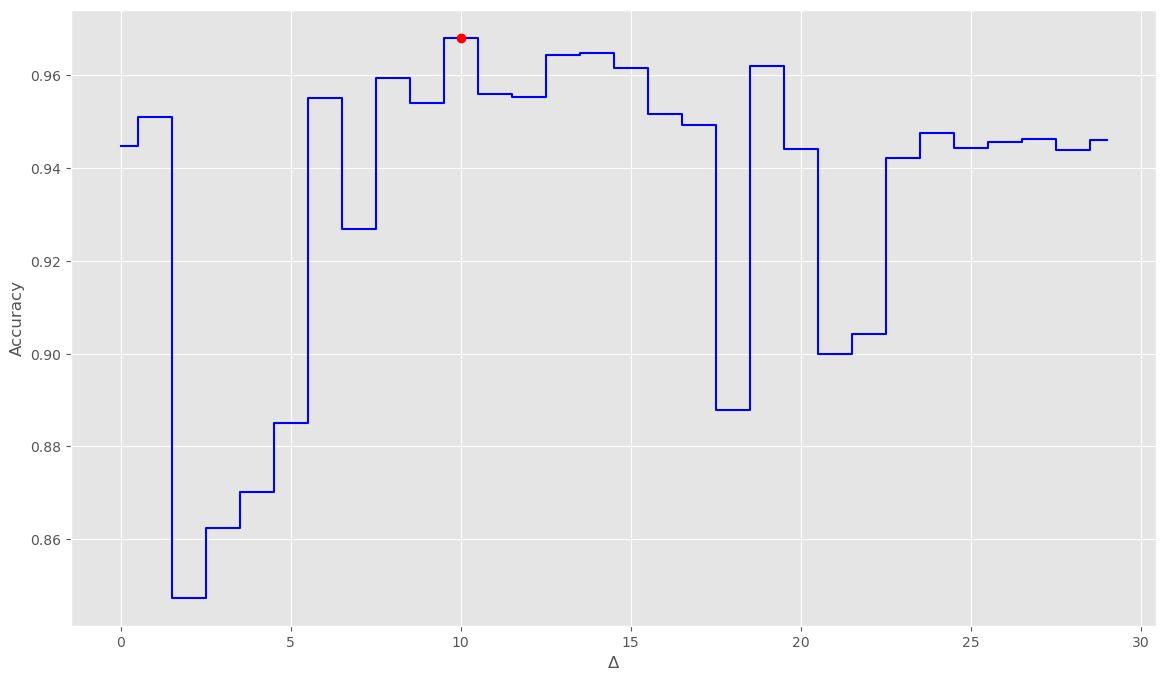

             Metrics     Train      Test
0   Overall Accuracy  0.999235  0.968136
1   Average Accuracy  0.998755  0.971870
2  kappa Coefficient  0.999131  0.958128
Best delta: 10


In [12]:
adj=4
quantization=8
training_set="STANDARD"

deltaMSER = run_grid_search(adj, quantization, training_set, [random.choice(seeds)])
print("Best delta:", deltaMSER)

In [14]:
adj=4
quantization=8
training_set="STANDARD"

import pandas as pd
df4 = pd.DataFrame(columns=["Method", "Dimension", "AO", "AA", "Kappa"])


deltaMSER = 10 # run_grid_search(adj, quantization, training_set)
methods = ["AP", "AAP", "MAX", "MIN", "SDAP", "LFAP", "LFSDAP", "ALPHA", "OMEGA", "FP_AREA", "FP_AREA_MEAN", "FP_MEAN"]#, "HAP", "HSDAP"]
for method in methods:
  print("\nMethod:", method)

  OCAs = []
  kappas = []
  ACAs = []
  for seed in seeds:
    OCA, kappa, ACA,classes, dim = run_experiment(method, adj, quantization, training_set, deltaMSER, seed)
    OCAs.append(OCA*100)
    kappas.append(kappa*100)
    ACAs.append(ACA*100)

  df4.loc[len(df4)] = {"Method":method, "Dimension":dim,
                     "AO":str(round(np.mean(OCAs),2)) + "  +/-"+ str(round(np.std(OCAs),2)),
                     "AA":str(round(np.mean(ACAs),2)) + "  +/- "+ str(round(np.std(ACAs),2)),
                     "Kappa":str(round(np.mean(kappas),2)) + "  +/- "+ str(round(np.std(kappas),2))
                     }
  print(df4)


Method: AP


Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

  Method  Dimension              AO             AA            Kappa
0     AP        116  92.74  +/-2.22  93.4  +/- 0.7  90.31  +/- 2.84

Method: AAP
  Method  Dimension              AO               AA            Kappa
0     AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1    AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16

Method: MAX


Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

  Method  Dimension              AO               AA            Kappa
0     AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1    AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2    MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11

Method: MIN


Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

  Method  Dimension              AO               AA            Kappa
0     AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1    AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2    MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11
3    MIN         60  87.35  +/-0.58  91.65  +/- 0.77   83.5  +/- 0.71

Method: SDAP


Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

  Method  Dimension              AO               AA            Kappa
0     AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1    AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2    MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11
3    MIN         60  87.35  +/-0.58  91.65  +/- 0.77   83.5  +/- 0.71
4   SDAP         60  93.59  +/-0.13  93.67  +/- 0.34  91.49  +/- 0.17

Method: LFAP


Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

  Method  Dimension              AO               AA            Kappa
0     AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1    AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2    MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11
3    MIN         60  87.35  +/-0.58  91.65  +/- 0.77   83.5  +/- 0.71
4   SDAP         60  93.59  +/-0.13  93.67  +/- 0.34  91.49  +/- 0.17
5   LFAP        232   94.8  +/-0.25  94.24  +/- 0.39  93.04  +/- 0.34

Method: LFSDAP


Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

   Method  Dimension              AO               AA            Kappa
0      AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1     AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2     MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11
3     MIN         60  87.35  +/-0.58  91.65  +/- 0.77   83.5  +/- 0.71
4    SDAP         60  93.59  +/-0.13  93.67  +/- 0.34  91.49  +/- 0.17
5    LFAP        232   94.8  +/-0.25  94.24  +/- 0.39  93.04  +/- 0.34
6  LFSDAP        120  95.41  +/-0.26  91.15  +/- 0.26  93.81  +/- 0.34

Method: ALPHA


Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

   Method  Dimension              AO               AA            Kappa
0      AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1     AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2     MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11
3     MIN         60  87.35  +/-0.58  91.65  +/- 0.77   83.5  +/- 0.71
4    SDAP         60  93.59  +/-0.13  93.67  +/- 0.34  91.49  +/- 0.17
5    LFAP        232   94.8  +/-0.25  94.24  +/- 0.39  93.04  +/- 0.34
6  LFSDAP        120  95.41  +/-0.26  91.15  +/- 0.26  93.81  +/- 0.34
7   ALPHA         60  91.67  +/-0.25  90.35  +/- 0.23  88.84  +/- 0.32

Method: OMEGA


Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

Total:   0%|          | 0/15 [00:00<?, ?it/s]

area:   0%|          | 0/15 [00:00<?, ?it/s]

   Method  Dimension              AO               AA            Kappa
0      AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1     AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2     MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11
3     MIN         60  87.35  +/-0.58  91.65  +/- 0.77   83.5  +/- 0.71
4    SDAP         60  93.59  +/-0.13  93.67  +/- 0.34  91.49  +/- 0.17
5    LFAP        232   94.8  +/-0.25  94.24  +/- 0.39  93.04  +/- 0.34
6  LFSDAP        120  95.41  +/-0.26  91.15  +/- 0.26  93.81  +/- 0.34
7   ALPHA         60  91.67  +/-0.25  90.35  +/- 0.23  88.84  +/- 0.32
8   OMEGA         60   92.4  +/-0.53  91.48  +/- 1.38  89.81  +/- 0.71

Method: FP_AREA


Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

    Method  Dimension              AO               AA            Kappa
0       AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1      AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2      MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11
3      MIN         60  87.35  +/-0.58  91.65  +/- 0.77   83.5  +/- 0.71
4     SDAP         60  93.59  +/-0.13  93.67  +/- 0.34  91.49  +/- 0.17
5     LFAP        232   94.8  +/-0.25  94.24  +/- 0.39  93.04  +/- 0.34
6   LFSDAP        120  95.41  +/-0.26  91.15  +/- 0.26  93.81  +/- 0.34
7    ALPHA         60  91.67  +/-0.25  90.35  +/- 0.23  88.84  +/- 0.32
8    OMEGA         60   92.4  +/-0.53  91.48  +/- 1.38  89.81  +/- 0.71
9  FP_AREA        116  84.85  +/-1.29  93.55  +/- 0.61  80.64  +/- 1.55

Method: FP_AREA_MEAN


Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

Total:   0%|          | 0/58 [00:00<?, ?it/s]

area:   0%|          | 0/58 [00:00<?, ?it/s]

          Method  Dimension              AO               AA            Kappa
0             AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1            AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2            MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11
3            MIN         60  87.35  +/-0.58  91.65  +/- 0.77   83.5  +/- 0.71
4           SDAP         60  93.59  +/-0.13  93.67  +/- 0.34  91.49  +/- 0.17
5           LFAP        232   94.8  +/-0.25  94.24  +/- 0.39  93.04  +/- 0.34
6         LFSDAP        120  95.41  +/-0.26  91.15  +/- 0.26  93.81  +/- 0.34
7          ALPHA         60  91.67  +/-0.25  90.35  +/- 0.23  88.84  +/- 0.32
8          OMEGA         60   92.4  +/-0.53  91.48  +/- 1.38  89.81  +/- 0.71
9        FP_AREA        116  84.85  +/-1.29  93.55  +/- 0.61  80.64  +/- 1.55
10  FP_AREA_MEAN        232   95.8  +/-0.18   96.08  +/- 0.3  94.35  +/- 0.24

Method: FP_MEAN


Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

Total:   0%|          | 0/29 [00:00<?, ?it/s]

area:   0%|          | 0/29 [00:00<?, ?it/s]

          Method  Dimension              AO               AA            Kappa
0             AP        116  92.74  +/-2.22    93.4  +/- 0.7  90.31  +/- 2.84
1            AAP        116  96.67  +/-0.12  97.07  +/- 0.28  95.54  +/- 0.16
2            MAX         60  87.54  +/-0.89  86.28  +/- 0.25  83.29  +/- 1.11
3            MIN         60  87.35  +/-0.58  91.65  +/- 0.77   83.5  +/- 0.71
4           SDAP         60  93.59  +/-0.13  93.67  +/- 0.34  91.49  +/- 0.17
5           LFAP        232   94.8  +/-0.25  94.24  +/- 0.39  93.04  +/- 0.34
6         LFSDAP        120  95.41  +/-0.26  91.15  +/- 0.26  93.81  +/- 0.34
7          ALPHA         60  91.67  +/-0.25  90.35  +/- 0.23  88.84  +/- 0.32
8          OMEGA         60   92.4  +/-0.53  91.48  +/- 1.38  89.81  +/- 0.71
9        FP_AREA        116  84.85  +/-1.29  93.55  +/- 0.61  80.64  +/- 1.55
10  FP_AREA_MEAN        232   95.8  +/-0.18   96.08  +/- 0.3  94.35  +/- 0.24
11       FP_MEAN        116   96.13  +/-0.3  96.23  +/- 0.32   9

In [ ]:
#print(df4.to_latex(index=False))
df4

\begin{tabular}{lllll}
\toprule
      Method & Dimension &             AO &              AA &           Kappa \\
\midrule
          AP &       116 & 92.74  +/-2.22 &   93.4  +/- 0.7 & 90.31  +/- 2.84 \\
         AAP &       116 & 96.67  +/-0.12 & 97.07  +/- 0.28 & 95.54  +/- 0.16 \\
         MAX &        60 & 87.54  +/-0.89 & 86.28  +/- 0.25 & 83.29  +/- 1.11 \\
         MIN &        60 & 87.35  +/-0.58 & 91.65  +/- 0.77 &  83.5  +/- 0.71 \\
        SDAP &        60 & 93.59  +/-0.13 & 93.67  +/- 0.34 & 91.49  +/- 0.17 \\
        LFAP &       232 &  94.8  +/-0.25 & 94.24  +/- 0.39 & 93.04  +/- 0.34 \\
      LFSDAP &       120 & 95.41  +/-0.26 & 91.15  +/- 0.26 & 93.81  +/- 0.34 \\
       ALPHA &        60 & 91.67  +/-0.25 & 90.35  +/- 0.23 & 88.84  +/- 0.32 \\
       OMEGA &        60 &  92.4  +/-0.53 & 91.48  +/- 1.38 & 89.81  +/- 0.71 \\
     FP\_AREA &       116 & 84.85  +/-1.29 & 93.55  +/- 0.61 & 80.64  +/- 1.55 \\
FP\_AREA\_MEAN &       232 & 96.07  +/-0.31 & 96.36  +/- 0.33 & 94.

,Method,Dimension,AO,AA,Kappa
0,AP,116,92.74 +/-2.22,93.4 +/- 0.7,90.31 +/- 2.84
1,AAP,116,96.67 +/-0.12,97.07 +/- 0.28,95.54 +/- 0.16
2,MAX,60,87.54 +/-0.89,86.28 +/- 0.25,83.29 +/- 1.11
3,MIN,60,87.35 +/-0.58,91.65 +/- 0.77,83.5 +/- 0.71
4,SDAP,60,93.59 +/-0.13,93.67 +/- 0.34,91.49 +/- 0.17
5,LFAP,232,94.8 +/-0.25,94.24 +/- 0.39,93.04 +/- 0.34
6,LFSDAP,120,95.41 +/-0.26,91.15 +/- 0.26,93.81 +/- 0.34
7,ALPHA,60,91.67 +/-0.25,90.35 +/- 0.23,88.84 +/- 0.32
8,OMEGA,60,92.4 +/-0.53,91.48 +/- 1.38,89.81 +/- 0.71
9,FP_AREA,116,84.85 +/-1.29,93.55 +/- 0.61,80.64 +/- 1.55


## Experimentos da Tabela 13
- Adj = 4
- Quantização: 8 bits
- Seleção do traingset: NEW

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .


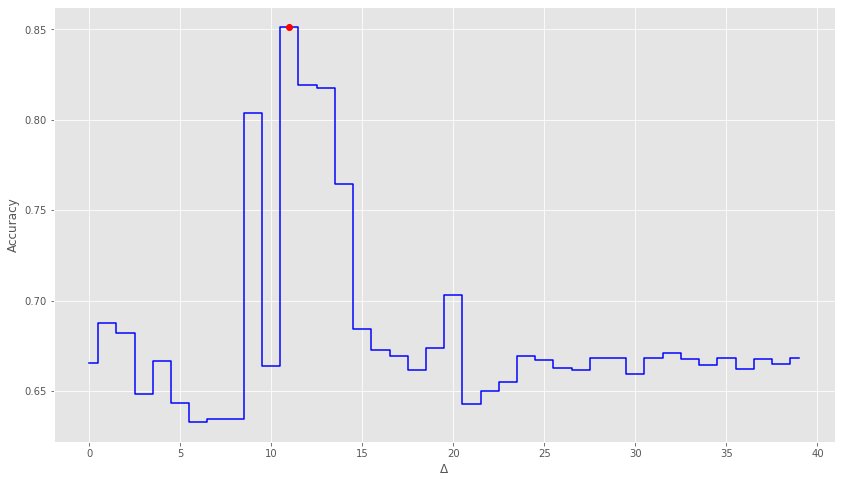

             Metrics  Train      Test
0   Overall Accuracy    1.0  0.851459
1   Average Accuracy    1.0  0.872364
2  kappa Coefficient    1.0  0.809241
Best delta: 11


In [132]:
adj=4
quantization=8
training_set="NEW"

deltaMSER = run_grid_search(adj, quantization, training_set, [random.choice(seeds)])
print("Best delta:", deltaMSER)

In [ ]:
adj=4
quantization=8
training_set="NEW"

import pandas as pd
df4 = pd.DataFrame(columns=["Method", "Dimension", "AO", "AA", "Kappa"])


deltaMSER = 11 # run_grid_search(adj, quantization, training_set)
methods = ["AP","AAP", "MAX", "MIN", "SDAP", "LFAP", "LFSDAP", "ALPHA", "OMEGA", "FP_AREA", "FP_AREA_MEAN", "FP_MEAN"]#, "HAP", "HSDAP"]
for method in methods:
  print("\nMethod:", method)

  OCAs = []
  kappas = []
  ACAs = []
  for seed in seeds:
    OCA, kappa, ACA,classes, dim = run_experiment(method, adj, quantization, training_set, deltaMSER, seed)
    OCAs.append(OCA*100)
    kappas.append(kappa*100)
    ACAs.append(ACA*100)

  df4.loc[len(df4)] = {"Method":method, "Dimension":dim,
                     "AO":str(round(np.mean(OCAs),2)) + "  +/-"+ str(round(np.std(OCAs),2)),
                     "AA":str(round(np.mean(ACAs),2)) + "  +/- "+ str(round(np.std(ACAs),2)),
                     "Kappa":str(round(np.mean(kappas),2)) + "  +/- "+ str(round(np.std(kappas),2))
                     }
  print(df4)

In [ ]:
print(df4.to_latex(index=False))
df4

\begin{tabular}{lllll}
\toprule
      Method & Dimension &             AO &              AA &           Kappa \\
\midrule
          AP &       116 & 64.06  +/-1.04 & 84.15  +/- 1.01 &  57.2  +/- 1.06 \\
         AAP &       116 & 85.61  +/-1.43 & 88.56  +/- 2.23 & 81.19  +/- 1.91 \\
         MAX &        60 & 58.91  +/-0.39 & 81.17  +/- 0.19 & 51.44  +/- 0.39 \\
         MIN &        60 & 72.34  +/-0.83 & 79.33  +/- 0.18 & 65.59  +/- 0.91 \\
        SDAP &        60 & 74.22  +/-2.29 &  79.2  +/- 0.54 & 67.88  +/- 2.52 \\
        LFAP &       232 &  81.1  +/-3.37 & 89.08  +/- 1.25 & 75.86  +/- 4.04 \\
      LFSDAP &       120 &  82.3  +/-2.01 & 83.28  +/- 0.94 & 77.08  +/- 2.37 \\
       ALPHA &        60 & 59.05  +/-1.64 & 68.98  +/- 0.86 & 50.56  +/- 1.71 \\
       OMEGA &        60 & 60.41  +/-1.54 & 69.41  +/- 0.94 & 51.92  +/- 1.65 \\
     FP\_AREA &       116 &  65.7  +/-0.95 & 81.76  +/- 1.34 &  58.78  +/- 1.0 \\
FP\_AREA\_MEAN &       232 & 72.06  +/-1.58 & 82.53  +/- 0.42 & 65.

,Method,Dimension,AO,AA,Kappa
0,AP,116,64.06 +/-1.04,84.15 +/- 1.01,57.2 +/- 1.06
1,AAP,116,85.61 +/-1.43,88.56 +/- 2.23,81.19 +/- 1.91
2,MAX,60,58.91 +/-0.39,81.17 +/- 0.19,51.44 +/- 0.39
3,MIN,60,72.34 +/-0.83,79.33 +/- 0.18,65.59 +/- 0.91
4,SDAP,60,74.22 +/-2.29,79.2 +/- 0.54,67.88 +/- 2.52
5,LFAP,232,81.1 +/-3.37,89.08 +/- 1.25,75.86 +/- 4.04
6,LFSDAP,120,82.3 +/-2.01,83.28 +/- 0.94,77.08 +/- 2.37
7,ALPHA,60,59.05 +/-1.64,68.98 +/- 0.86,50.56 +/- 1.71
8,OMEGA,60,60.41 +/-1.54,69.41 +/- 0.94,51.92 +/- 1.65
9,FP_AREA,116,65.7 +/-0.95,81.76 +/- 1.34,58.78 +/- 1.0


## Experimentos da Tabela 11
- Adj = 8
- Quantização: 8 bits
- Seleção do traingset: STANDARD

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .


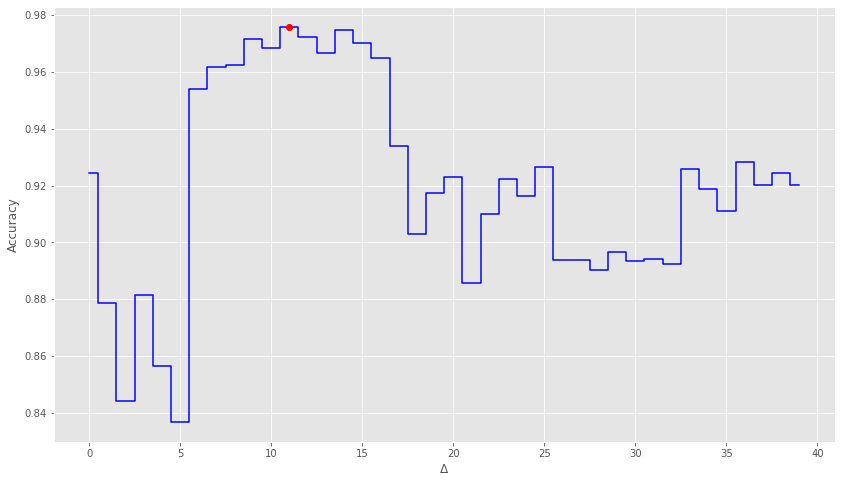

             Metrics     Train      Test
0   Overall Accuracy  0.999235  0.975921
1   Average Accuracy  0.998755  0.982407
2  kappa Coefficient  0.999131  0.968310
Best delta: 11


In [135]:
adj=8
quantization=8
training_set="STANDARD"

deltaMSER = run_grid_search(adj, quantization, training_set, [random.choice(seeds)])
print("Best delta:", deltaMSER)

In [ ]:
adj=8
quantization=8
training_set="STANDARD"

import pandas as pd
df8 = pd.DataFrame(columns=["Method", "Dimension", "AO", "AA", "Kappa"])


deltaMSER = 11 # run_grid_search(adj, quantization, training_set)
methods = ["AP", "AAP", "MAX", "MIN", "SDAP", "LFAP", "LFSDAP", "ALPHA", "OMEGA", "FP_AREA", "FP_AREA_MEAN", "FP_MEAN"]#, "HAP", "HSDAP"]
for method in methods:
  print("\nMethod:", method)

  OCAs = []
  kappas = []
  ACAs = []
  for seed in seeds:
    OCA, kappa, ACA,classes, dim = run_experiment(method, adj, quantization, training_set, deltaMSER, seed)
    OCAs.append(OCA*100)
    kappas.append(kappa*100)
    ACAs.append(ACA*100)

  df8.loc[len(df8)] = {"Method":method, "Dimension":dim,
                     "AO":str(round(np.mean(OCAs),2)) + "  +/-"+ str(round(np.std(OCAs),2)),
                     "AA":str(round(np.mean(ACAs),2)) + "  +/- "+ str(round(np.std(ACAs),2)),
                     "Kappa":str(round(np.mean(kappas),2)) + "  +/- "+ str(round(np.std(kappas),2))
                     }
  print(df8)

In [ ]:
print(df8.to_latex(index=False))
df8

\begin{tabular}{lllll}
\toprule
      Method & Dimension &             AO &              AA &           Kappa \\
\midrule
          AP &       116 & 90.91  +/-1.02 & 93.71  +/- 0.25 &  87.76  +/- 1.3 \\
         AAP &       116 & 97.43  +/-0.08 &  98.15  +/- 0.1 &  96.56  +/- 0.1 \\
         MAX &        60 & 84.14  +/-2.42 & 88.16  +/- 0.59 & 79.61  +/- 2.84 \\
         MIN &        60 & 78.51  +/-0.46 & 87.85  +/- 0.21 & 72.55  +/- 0.53 \\
        SDAP &        60 & 93.59  +/-0.13 & 93.67  +/- 0.34 & 91.49  +/- 0.17 \\
        LFAP &       232 & 92.37  +/-0.29 & 92.43  +/- 0.19 & 89.73  +/- 0.38 \\
      LFSDAP &       120 & 95.41  +/-0.26 & 91.15  +/- 0.26 & 93.81  +/- 0.34 \\
       ALPHA &        60 &  94.1  +/-0.06 & 94.98  +/- 0.15 & 92.15  +/- 0.08 \\
       OMEGA &        60 & 94.17  +/-0.09 & 95.05  +/- 0.21 & 92.24  +/- 0.12 \\
     FP\_AREA &       116 & 88.72  +/-1.75 & 93.71  +/- 0.41 & 85.02  +/- 2.21 \\
FP\_AREA\_MEAN &       232 & 94.08  +/-0.39 & 95.05  +/- 0.38 & 91.

,Method,Dimension,AO,AA,Kappa
0,AP,116,90.91 +/-1.02,93.71 +/- 0.25,87.76 +/- 1.3
1,AAP,116,97.43 +/-0.08,98.15 +/- 0.1,96.56 +/- 0.1
2,MAX,60,84.14 +/-2.42,88.16 +/- 0.59,79.61 +/- 2.84
3,MIN,60,78.51 +/-0.46,87.85 +/- 0.21,72.55 +/- 0.53
4,SDAP,60,93.59 +/-0.13,93.67 +/- 0.34,91.49 +/- 0.17
5,LFAP,232,92.37 +/-0.29,92.43 +/- 0.19,89.73 +/- 0.38
6,LFSDAP,120,95.41 +/-0.26,91.15 +/- 0.26,93.81 +/- 0.34
7,ALPHA,60,94.1 +/-0.06,94.98 +/- 0.15,92.15 +/- 0.08
8,OMEGA,60,94.17 +/-0.09,95.05 +/- 0.21,92.24 +/- 0.12
9,FP_AREA,116,88.72 +/-1.75,93.71 +/- 0.41,85.02 +/- 2.21


. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .


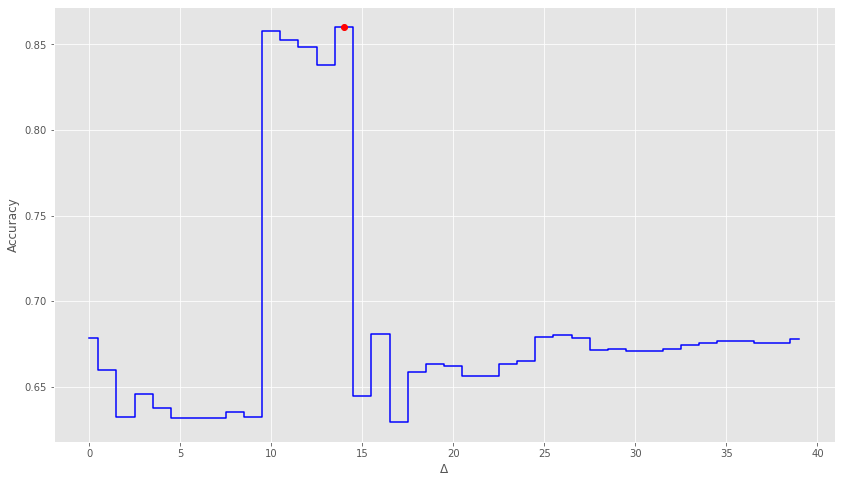

             Metrics  Train      Test
0   Overall Accuracy    1.0  0.860295
1   Average Accuracy    1.0  0.905459
2  kappa Coefficient    1.0  0.822380
Best delta: 14


In [138]:
adj=8
quantization=8
training_set="NEW"

deltaMSER = run_grid_search(adj, quantization, training_set, [random.choice(seeds)])
print("Best delta:", deltaMSER)

In [ ]:
adj=8
quantization=8
training_set="NEW"

import pandas as pd
df8 = pd.DataFrame(columns=["Method", "Dimension", "AO", "AA", "Kappa"])


deltaMSER = 10 # run_grid_search(adj, quantization, training_set)
methods = ["AP", "AAP", "MAX", "MIN", "SDAP", "LFAP", "LFSDAP", "ALPHA", "OMEGA", "FP_AREA", "FP_AREA_MEAN", "FP_MEAN"]#, "HAP", "HSDAP"]

for method in methods:
  print("\nMethod:", method)

  OCAs = []
  kappas = []
  ACAs = []
  for seed in seeds:
    OCA, kappa, ACA,classes, dim = run_experiment(method, adj, quantization, training_set, deltaMSER, seed)
    OCAs.append(OCA*100)
    kappas.append(kappa*100)
    ACAs.append(ACA*100)
  df8.loc[len(df8)] = {"Method":method, "Dimension":dim,
                     "AO":str(round(np.mean(OCAs),2)) + "  +/-"+ str(round(np.std(OCAs),2)),
                     "AA":str(round(np.mean(ACAs),2)) + "  +/- "+ str(round(np.std(ACAs),2)),
                     "Kappa":str(round(np.mean(kappas),2)) + "  +/- "+ str(round(np.std(kappas),2))
                     }
  print(df8)

In [206]:
print(df8.to_latex(index=False))
df8

\begin{tabular}{lllll}
\toprule
      Method & Dimension &             AO &              AA &           Kappa \\
\midrule
          AP &       116 & 64.12  +/-0.66 &  84.4  +/- 0.17 & 57.24  +/- 0.67 \\
         AAP &       116 & 84.41  +/-0.28 &  89.4  +/- 0.08 & 79.75  +/- 0.34 \\
         MAX &        60 &  59.5  +/-0.79 & 80.74  +/- 0.31 & 51.87  +/- 0.79 \\
         MIN &        60 & 71.99  +/-1.83 &  78.8  +/- 1.34 & 65.13  +/- 1.98 \\
        SDAP &        60 & 74.22  +/-2.29 &  79.2  +/- 0.54 & 67.88  +/- 2.52 \\
        LFAP &       232 & 84.19  +/-1.07 & 87.81  +/- 0.29 &  78.9  +/- 1.31 \\
      LFSDAP &       120 &  82.3  +/-2.01 & 83.28  +/- 0.94 & 77.08  +/- 2.37 \\
       ALPHA &        60 & 61.62  +/-0.59 &  70.65  +/- 1.1 & 53.21  +/- 0.69 \\
       OMEGA &        60 & 61.18  +/-0.77 &  71.5  +/- 0.59 &  53.1  +/- 0.79 \\
     FP\_AREA &       116 & 68.92  +/-0.86 &  85.6  +/- 0.65 & 62.27  +/- 0.89 \\
FP\_AREA\_MEAN &       232 & 73.94  +/-0.84 & 87.45  +/- 0.38 &  67

,Method,Dimension,AO,AA,Kappa
0,AP,116,64.12 +/-0.66,84.4 +/- 0.17,57.24 +/- 0.67
1,AAP,116,84.41 +/-0.28,89.4 +/- 0.08,79.75 +/- 0.34
2,MAX,60,59.5 +/-0.79,80.74 +/- 0.31,51.87 +/- 0.79
3,MIN,60,71.99 +/-1.83,78.8 +/- 1.34,65.13 +/- 1.98
4,SDAP,60,74.22 +/-2.29,79.2 +/- 0.54,67.88 +/- 2.52
5,LFAP,232,84.19 +/-1.07,87.81 +/- 0.29,78.9 +/- 1.31
6,LFSDAP,120,82.3 +/-2.01,83.28 +/- 0.94,77.08 +/- 2.37
7,ALPHA,60,61.62 +/-0.59,70.65 +/- 1.1,53.21 +/- 0.69
8,OMEGA,60,61.18 +/-0.77,71.5 +/- 0.59,53.1 +/- 0.79
9,FP_AREA,116,68.92 +/-0.86,85.6 +/- 0.65,62.27 +/- 0.89


In [ ]:
run_experiment("FP_MEAN", adj, quantization, training_set, deltaMSER, seed)

# Experiments with Dalla Mura's Model

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .


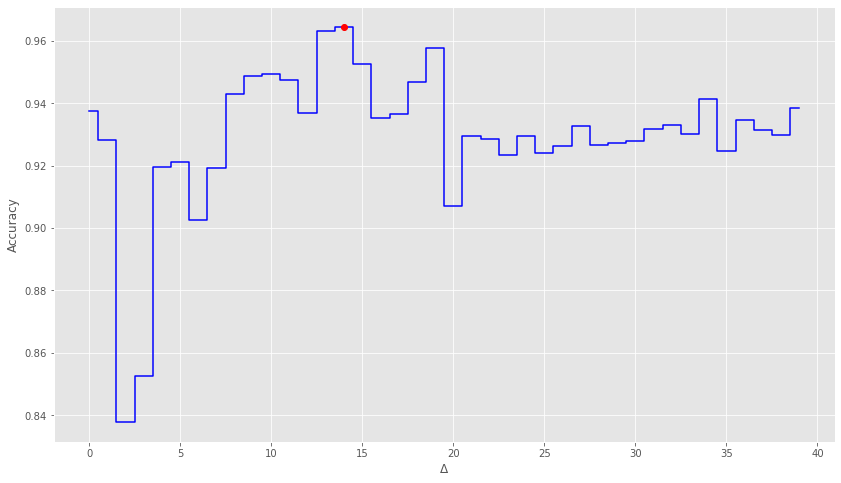

             Metrics  Train      Test
0   Overall Accuracy    1.0  0.964560
1   Average Accuracy    1.0  0.971219
2  kappa Coefficient    1.0  0.953398
Best delta: 14


In [32]:
adj=4
quantization=8
training_set="STANDARD"
lambdas = [100, 500, 1000, 5000]

deltaMSER =  run_grid_search(adj, quantization, training_set, [random.choice(seeds)], lambdas, numPCs=3)
print("Best delta:", deltaMSER)

In [ ]:
adj=4
quantization=8
training_set="STANDARD"
lambdas = [100, 500, 1000, 5000]

import pandas as pd
df4 = pd.DataFrame(columns=["Method", "Dimension", "AO", "AA", "Kappa"])


deltaMSER = 14 # run_grid_search(adj, quantization, training_set, [random.choice(seeds)], lambdas, numPCs=4)
methods = ["AP", "AAP"]
for method in methods:
  print("\nMethod:", method)

  OCAs = []
  kappas = []
  ACAs = []
  for seed in seeds:
    OCA, kappa, ACA,classes, dim = run_experiment(method, adj, quantization, training_set, deltaMSER, seed, False, lambdas, 3)
    OCAs.append(OCA*100)
    kappas.append(kappa*100)
    ACAs.append(ACA*100)

  df4.loc[len(df4)] = {"Method":method, "Dimension":dim,
                     "AO":str(round(np.mean(OCAs),2)) + "  +/-"+ str(round(np.std(OCAs),2)),
                     "AA":str(round(np.mean(ACAs),2)) + "  +/- "+ str(round(np.std(ACAs),2)),
                     "Kappa":str(round(np.mean(kappas),2)) + "  +/- "+ str(round(np.std(kappas),2))
                     }
  print(df4)

In [34]:
df4

,Method,Dimension,AO,AA,Kappa
0,AP,27,92.63 +/-0.61,91.56 +/- 0.55,90.0 +/- 0.86
1,AAP,27,96.17 +/-0.21,96.66 +/- 0.17,94.87 +/- 0.28


# Experiments with Pham's Model

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .


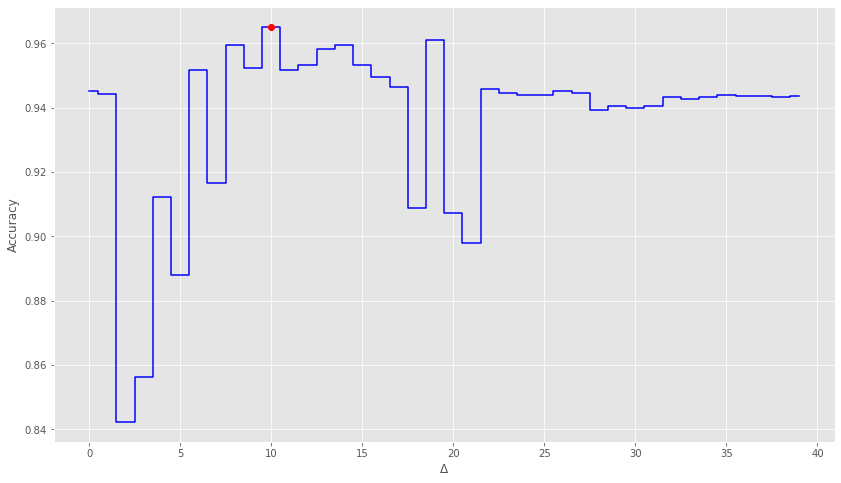

             Metrics     Train      Test
0   Overall Accuracy  0.998725  0.965214
1   Average Accuracy  0.998457  0.972200
2  kappa Coefficient  0.998552  0.954334
Best delta: 10


In [35]:
adj=4
quantization=8
training_set="STANDARD"
lambdas = [770, 1538, 2307, 3076, 3846, 4615, 5384, 6153, 6923, 7692, 8461, 9230, 10000, 10769]

deltaMSER =  run_grid_search(adj, quantization, training_set, [random.choice(seeds)], lambdas, numPCs=3)
print("Best delta:", deltaMSER)

In [ ]:
adj=4
quantization=8
training_set="STANDARD"
lambdas = [770, 1538, 2307, 3076, 3846, 4615, 5384, 6153, 6923, 7692, 8461, 9230, 10000, 10769]

import pandas as pd
df4 = pd.DataFrame(columns=["Method", "Dimension", "AO", "AA", "Kappa"])


deltaMSER = 10 # run_grid_search(adj, quantization, training_set, [random.choice(seeds)], lambdas, numPCs=4)
methods = ["AP", "AAP"]
for method in methods:
  print("\nMethod:", method)

  OCAs = []
  kappas = []
  ACAs = []
  for seed in seeds:
    OCA, kappa, ACA,classes, dim = run_experiment(method, adj, quantization, training_set, deltaMSER, seed, False, lambdas, 3)
    OCAs.append(OCA*100)
    kappas.append(kappa*100)
    ACAs.append(ACA*100)

  df4.loc[len(df4)] = {"Method":method, "Dimension":dim,
                     "AO":str(round(np.mean(OCAs),2)) + "  +/-"+ str(round(np.std(OCAs),2)),
                     "AA":str(round(np.mean(ACAs),2)) + "  +/- "+ str(round(np.std(ACAs),2)),
                     "Kappa":str(round(np.mean(kappas),2)) + "  +/- "+ str(round(np.std(kappas),2))
                     }
  print(df4)

In [39]:
df4

,Method,Dimension,AO,AA,Kappa
0,AP,87,93.12 +/-2.49,93.06 +/- 0.61,90.79 +/- 3.14
1,AAP,87,96.35 +/-0.1,96.84 +/- 0.13,95.12 +/- 0.14
